In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
import re
import numpy as np
import seaborn as sns
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage import io
from patchify import patchify, unpatchify
%matplotlib inline

import collections
# from itertools import chain
# import urllib.request as request
# import pickle

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

# import cv2

# from libsvm import svmutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [2]:
fog_aware_pivot = pd.read_csv('fog_aware_stats_pivot.csv')
fog_aware_pivot['Label_train'] = 1*(fog_aware_pivot['Label']=='foggy')

In [3]:
fog_aware_pivot[['Label_train', 'Label']].value_counts()

Label_train  Label    
0            not_foggy    6851
1            foggy        1776
dtype: int64

In [4]:
from sklearn import preprocessing
X = np.array(fog_aware_pivot[['mscn_var_0', 'mscn_var_1',
       'mscn_var_2', 'mscn_var_3', 'vertical_var_0', 'vertical_var_1',
       'vertical_var_2', 'vertical_var_3', 'sharpness_0', 'sharpness_1',
       'sharpness_2', 'sharpness_3', 'coef_or_var_sharpness_0',
       'coef_or_var_sharpness_1', 'coef_or_var_sharpness_2',
       'coef_or_var_sharpness_3', 'entropy_0',
       'entropy_1', 'entropy_2', 'entropy_3',
       'color_sat_0', 'color_sat_1', 'color_sat_2', 'color_sat_3', 'CF_0',
       'CF_1', 'CF_2', 'CF_3']].dropna()
            )
####scale to mean and std

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

y = np.array(fog_aware_pivot['Label_train'])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.20, random_state=42, stratify = y)

n_classes = len(np.unique(y_train))


In [5]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
  test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
  group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
  group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  # Creating the heatmap
  plt.figure(figsize=(10,7))
  sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
  plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()

In [6]:
##### logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())
print( 'Train accuracy: %.2f' % train_accuracy)

y_test_pred = clf.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())
print('Test accuracy: %.2f' % test_accuracy)


Train accuracy: 0.92
Test accuracy: 0.92


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.9200463499420626
Precision: 0.8258258258258259
Recall: 0.7746478873239436
F1 Score: 0.7994186046511628
AUC-ROC Score: 0.9503477465816049


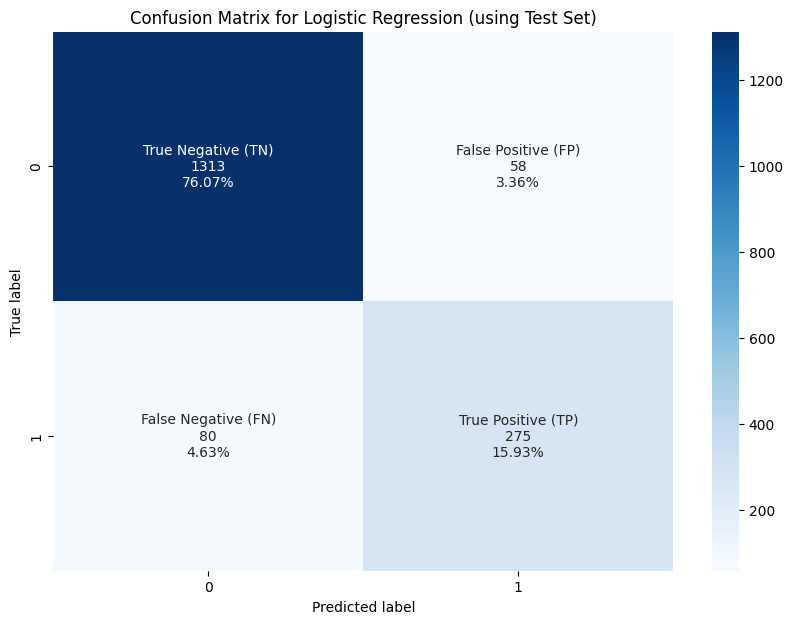

In [8]:
plot_confusion_matrix(y_test, y_test_pred, "Logistic Regression")

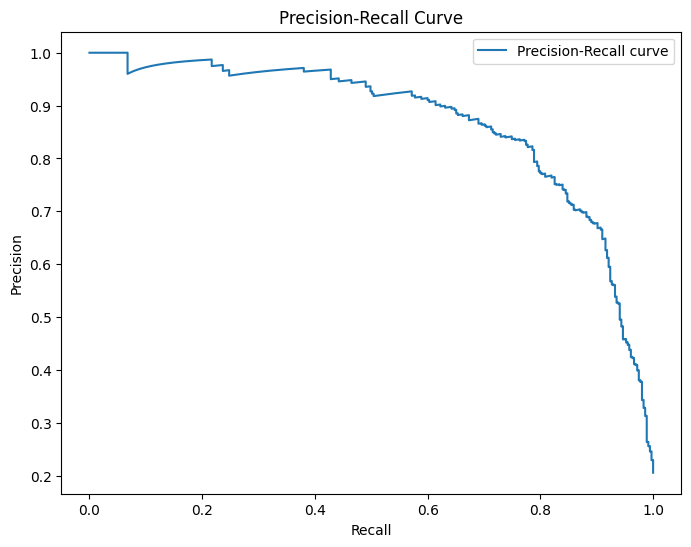

In [9]:
y_scores = clf.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

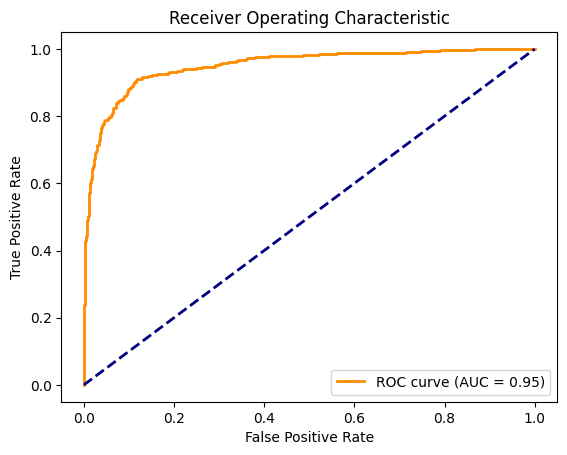

In [10]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
##### support vector machine
threshold = 0.5

#SVM using RBF kernel
from sklearn import svm
regr = svm.SVR(kernel='rbf')
regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy: %.2f' % train_accuracy)

y_test_pred = regr.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy: %.2f' % test_accuracy)


Train accuracy: 0.94
Test accuracy: 0.92


In [12]:
accuracy = accuracy_score(y_test, y_test_pred_binary)
precision = precision_score(y_test, y_test_pred_binary)
recall = recall_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
roc_auc = roc_auc_score(y_test, regr.predict(X_test))

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.9194669756662804
Precision: 0.8461538461538461
Recall: 0.7436619718309859
F1 Score: 0.7916041979010494
AUC-ROC Score: 0.9511654903894556


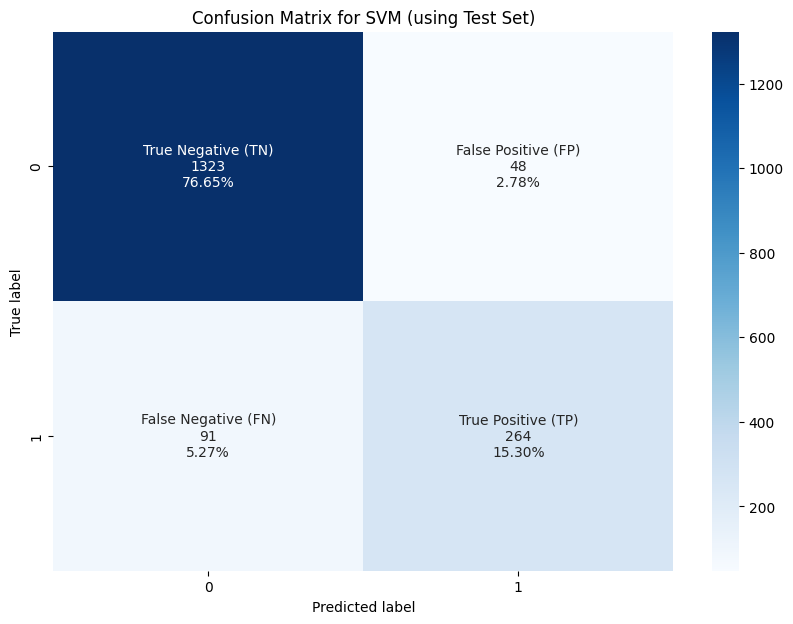

In [13]:
plot_confusion_matrix(y_test, y_test_pred_binary, "SVM")

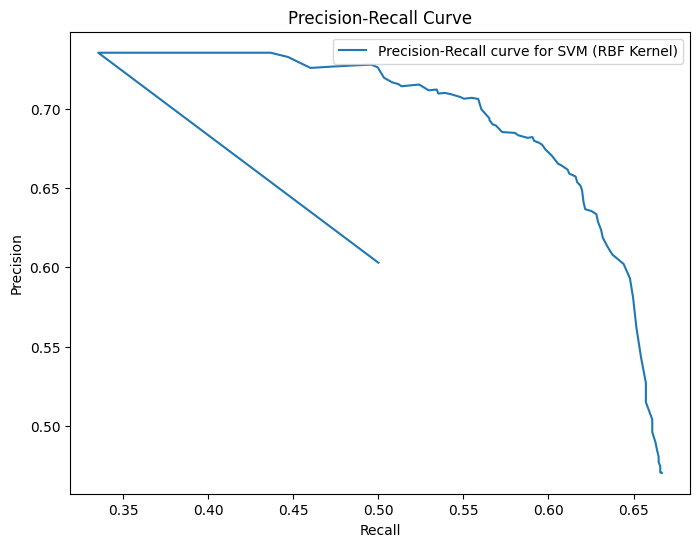

In [14]:
y_scores = regr.predict(X_test)

# Generate a range of thresholds from the minimum to the maximum predicted scores
thresholds = np.linspace(min(y_scores), max(y_scores), 100)

# Initialize lists to store precision and recall values
precisions = []
recalls = []

for t in thresholds:
  # Convert continuous predictions to binary predictions based on the current threshold
  y_pred_binary = (y_scores > t).astype(int)

  # Calculate precision and recall
  precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)

  # Store the average precision and recall for the current threshold
  precisions.append(np.mean(precision))
  recalls.append(np.mean(recall))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve for SVM (RBF Kernel)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

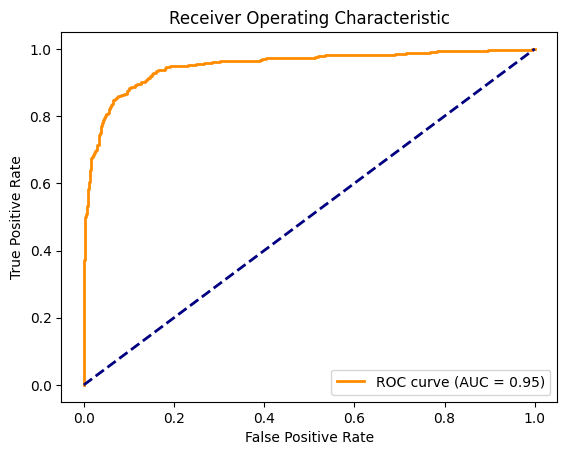

In [15]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, regr.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
#SVM using linear kernel
regr_linear = svm.SVR(kernel='linear')
regr_linear.fit(X_train, y_train)

y_train_pred = regr_linear.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print('Train accuracy for SVM with linear kernel: %.2f' % train_accuracy)

y_test_pred = regr_linear.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with linear kernel: %.2f' % test_accuracy)

Train accuracy for SVM with linear kernel: 0.89
Test accuracy for SVM with linear kernel: 0.88


In [17]:
#SVM using polynomial kernel
regr_poly = svm.SVR(kernel='poly', degree=3)
regr_poly.fit(X_train, y_train)

y_train_pred = regr_poly.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy for SVM with polynomial kernel of degree 3: %.2f' % train_accuracy)

y_test_pred = regr_poly.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with polynomial kernel of degree 3: %.2f' % test_accuracy)

Train accuracy for SVM with polynomial kernel of degree 3: 0.91
Test accuracy for SVM with polynomial kernel of degree 3: 0.90


In [18]:
#SVM using sigmoid kernel
regr_sigmoid = svm.SVR(kernel='sigmoid')
regr_sigmoid.fit(X_train, y_train)

y_train_pred = regr_sigmoid.predict(X_train)
y_train_pred_binary = (y_train_pred > threshold).astype(int)
train_accuracy = np.mean(y_train_pred_binary.ravel() == y_train.ravel())
print( 'Train accuracy for SVM with sigmoid kernel: %.2f' % train_accuracy)

y_test_pred = regr_sigmoid.predict(X_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)
test_accuracy = np.mean(y_test_pred_binary.ravel() == y_test.ravel())
print('Test accuracy for SVM with sigmoid kernel: %.2f' % test_accuracy)

Train accuracy for SVM with sigmoid kernel: 0.46
Test accuracy for SVM with sigmoid kernel: 0.46


In [19]:
#### GMM

gmm = GaussianMixture(n_components=n_classes
                    # ,covariance_type='diag'
                      , init_params='random_from_data')
gmm.fit(X_train)
y_train_pred = gmm.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)
print( 'Train accuracy: %.2f' % train_accuracy)

y_test_pred = gmm.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())
print('Test accuracy: %.2f' % test_accuracy)


Train accuracy: 0.32
Test accuracy: 0.33


In [20]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, gmm.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.32966396292004635
Precision: 0.07066381156316917
Recall: 0.18591549295774648
F1 Score: 0.10240496508921645
AUC-ROC Score: 0.18164185697701896


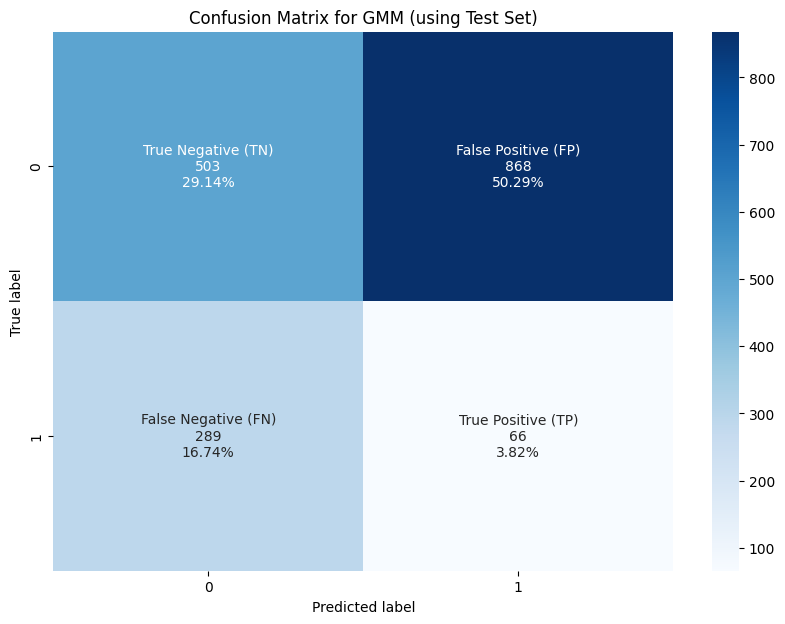

In [21]:
plot_confusion_matrix(y_test, y_test_pred, "GMM")

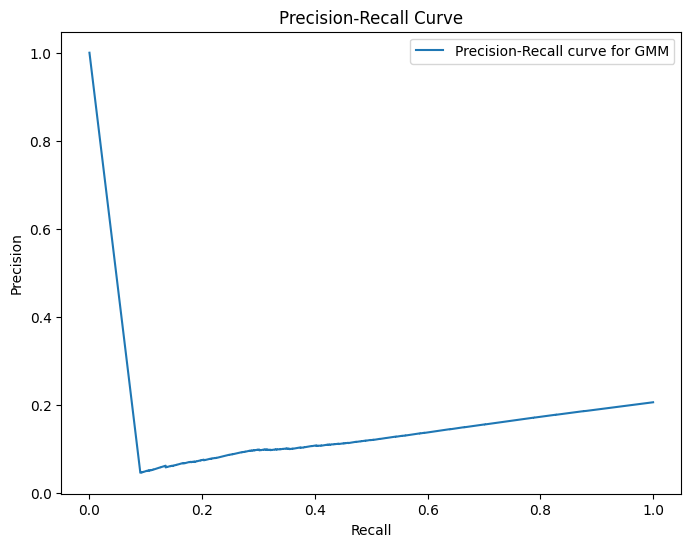

In [22]:
y_scores = gmm.predict_proba(X_test)

y_scores_class = y_scores[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_class)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve for GMM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

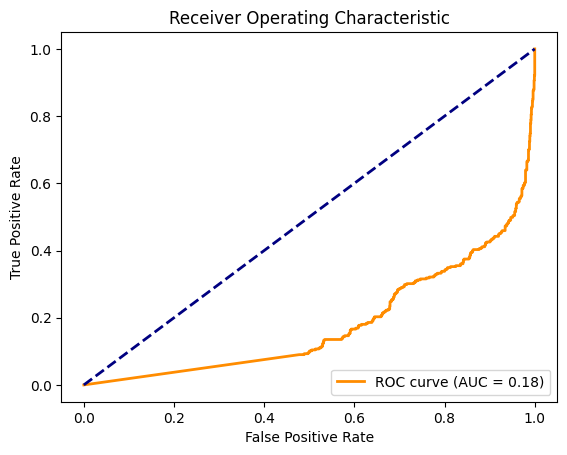

In [23]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, gmm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()